# Missteering measurement using AC dipole excitation


In [6]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.07.02
Your IP is 172.17.0.17
2018-07-03 13:06:18


---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [7]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [8]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [9]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 215 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.16.19.35.398.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.20.32.16.081.mat


In [10]:
df1 = myToolbox.fromMatlabToDataFrame(files[101:116],matlabVars,verbose=False)
df1['label'] = 'ACD@C200'
df2 = myToolbox.fromMatlabToDataFrame(files[117:134],matlabVars,verbose=False)
df2['label'] = 'ACD@C200_2'
df3 = myToolbox.fromMatlabToDataFrame(files[135:150],matlabVars,verbose=False)
df3['label'] = 'C265Reference'
df4 = myToolbox.fromMatlabToDataFrame(files[151:166],matlabVars,verbose=False)
df4['label'] = 'ACD@C300'
df5 = myToolbox.fromMatlabToDataFrame(files[176:192],matlabVars,verbose=False)
df5['label'] = 'C400Reference'
df6 = myToolbox.fromMatlabToDataFrame(files[192:],matlabVars,verbose=False)
df6['label'] = 'C300Reference'

In [11]:
myDataFrame = pnd.concat([df1,df2,df3,df4,df5,df6])

# Data cleanup

In [12]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-07-02 18:36:10.300000'].name) # non-phys emittance

Dropped 5 duplicate(s)
---
BPM data ok
---


# Import the optics model

In [13]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Match the tomogram data

In [14]:
myDataFrame['deltaP_P_rms'] = 0.83e-3
myDataFrame['beta'] = 0.915095
myDataFrame['gamma'] =  2.479919

# Save the imported data

In [15]:
myDataFrame.to_pickle('imported_data_2018.07.02.pkl')

In [16]:
# myDataFrame=pnd.read_pickle('imported_data_2018.07.02.pkl')

# Intensity

In [17]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

Text(0,0.5,u'Losses')

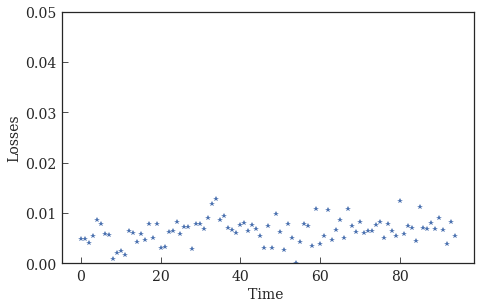

In [18]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

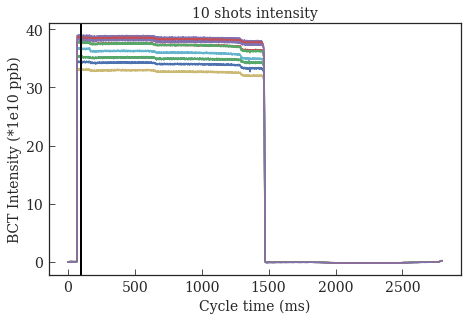

In [19]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [20]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Y plane

In [22]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [23]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

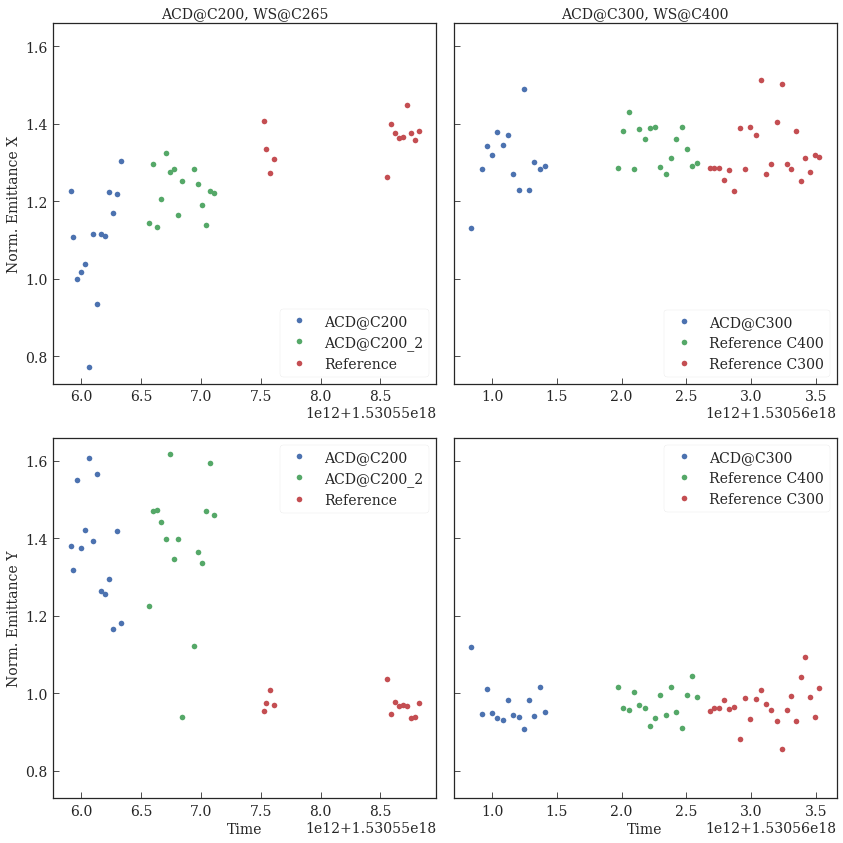

In [45]:
fig, ax = plt.subplots(2,2,figsize=(12,12), sharey=True)

# ACD@C200
emiC200 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200']
ax[0,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[0,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference']
ax[0,0].plot(refC265,'o',label = 'Reference')

ax[0,0].set_title('ACD@C200, WS@C265')
ax[0,0].set_ylabel('Norm. Emittance X')
ax[0,0].legend(frameon=True,loc=4)

emiC200 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200']
ax[1,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[1,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference']
ax[1,0].plot(refC265,'o',label = 'Reference')

ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Norm. Emittance Y')
ax[1,0].legend(frameon=True)


# ACD@C300
emiC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300']
ax[0,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference']
ax[0,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference']
ax[0,1].plot(refC300,'o',label = 'Reference C300')

ax[0,1].set_title('ACD@C300, WS@C400')
ax[0,1].legend(frameon=True,loc=4)

emiC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300']
ax[1,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference']
ax[1,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference']
ax[1,1].plot(refC300,'o',label = 'Reference C300')

ax[1,1].set_xlabel('Time')
ax[1,1].legend(frameon=True)


fig.tight_layout()

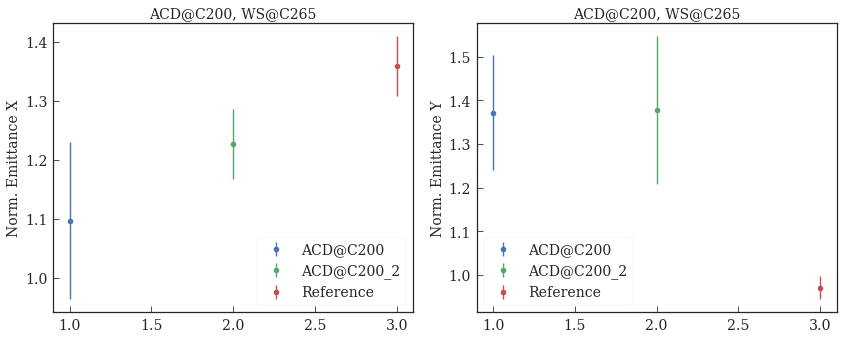

In [46]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[0].set_title('ACD@C200, WS@C265')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[1].set_title('ACD@C200, WS@C265')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True,loc=3)

fig.tight_layout()

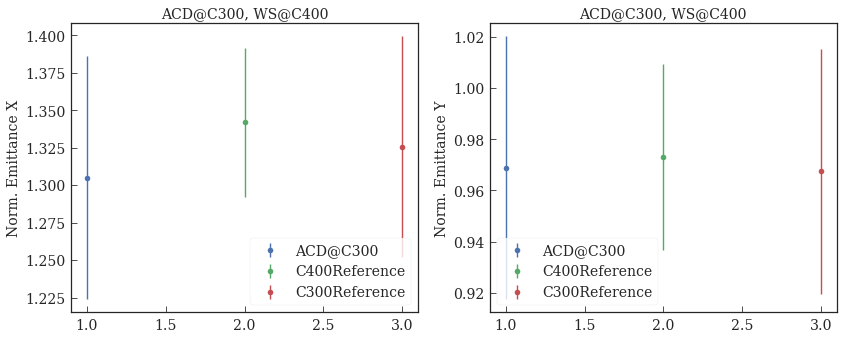

In [47]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[0].set_title('ACD@C300, WS@C400')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[1].set_title('ACD@C300, WS@C400')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True,loc=3)

fig.tight_layout()

# BPMs

In [28]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [29]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Calculate injection oscillation from the BPM

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [30]:
# get the beta at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]

In [31]:
# loop over all the BPM

# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# fit boundaries 
bounds=([-np.inf, 1.*pi/5, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])
# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:30]).values[k]
        # starting values
        p0 = ([2*signalRMS(ydata), 0.45*pi, pi/2, np.mean(ydata)])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)

        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

PR.BPM00 processed with success 129/129 shots
PR.BPM03 processed with success 129/129 shots
PR.BPM05 processed with success 129/129 shots
PR.BPM07 processed with success 129/129 shots
PR.BPM10 processed with success 129/129 shots
PR.BPM13 processed with success 129/129 shots
PR.BPM15 processed with success 129/129 shots
PR.BPM17 processed with success 129/129 shots
PR.BPM20 processed with success 129/129 shots
PR.BPM23 processed with success 129/129 shots
PR.BPM25 processed with success 129/129 shots
fit do not converge on shot 110
PR.BPM27 processed with success 128/129 shots
PR.BPM30 processed with success 129/129 shots
PR.BPM33 processed with success 129/129 shots
PR.BPM35 processed with success 129/129 shots
PR.BPM37 processed with success 129/129 shots
PR.BPM40 processed with success 129/129 shots
PR.BPM43 processed with success 129/129 shots
PR.BPM45 processed with success 129/129 shots
PR.BPM47 processed with success 129/129 shots
PR.BPM50 processed with success 129/129 shots
PR

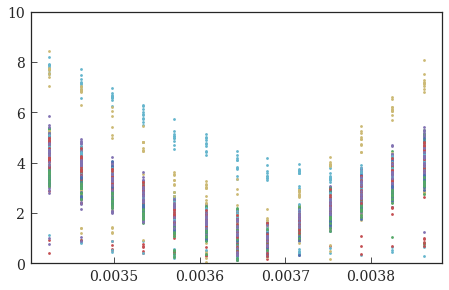

In [32]:
# sanity check 
for k in range(34):
    plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,10))

Beta_x at PR.BPM45: 22.64823339


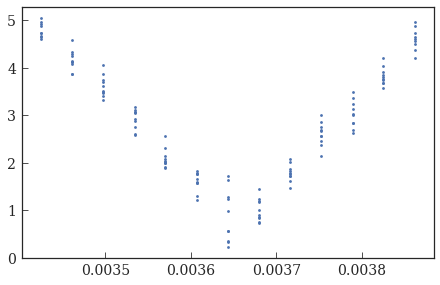

In [33]:
# manual inspection
bpm_n = 18
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

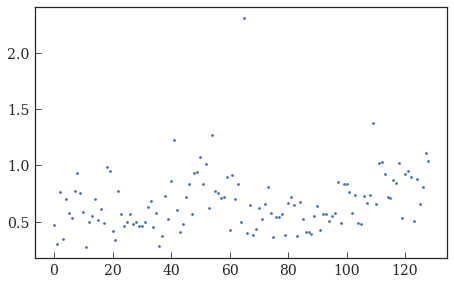

In [34]:
plt.plot(chi2[:,bpm_n],'.')

Text(0,0.5,u'Shot number')

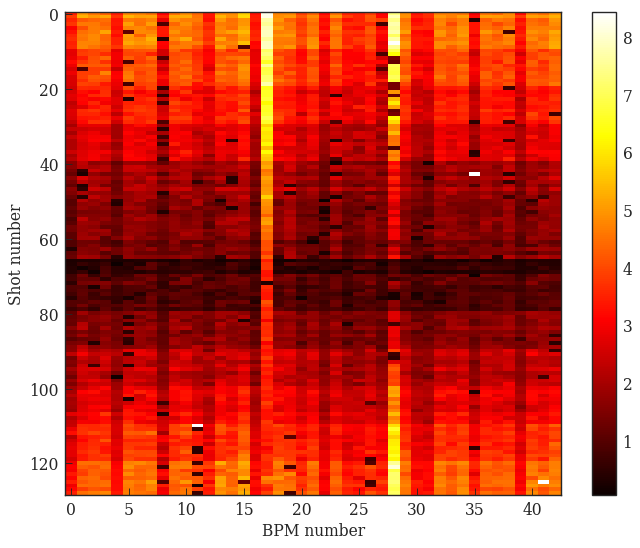

In [35]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar()
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [36]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

# myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

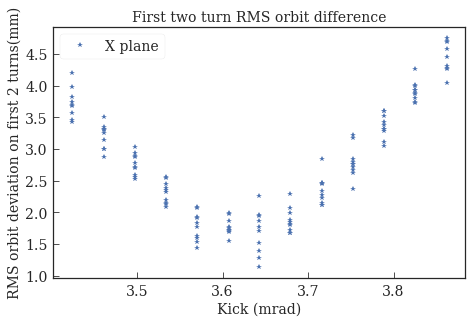

In [37]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

# plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

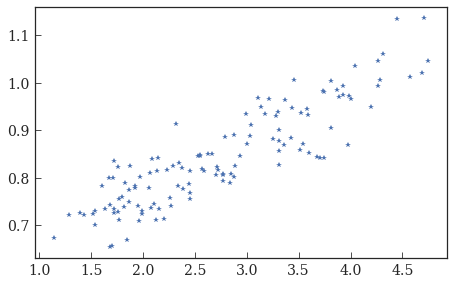

In [38]:
plt.plot(myDataFrame['deltaX_2turns'].values, myDataFrame['WS_geom_emittance_x'],'*',label='X plane')


In [39]:
xrms12_mean = np.empty(len(ks_idx),dtype=float)
xrms12_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 



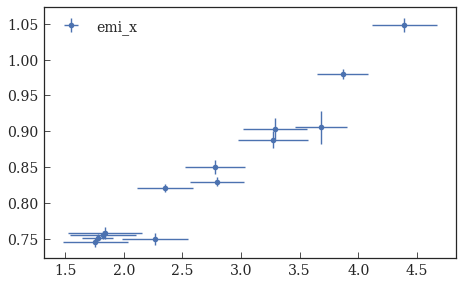

In [40]:
plt.errorbar(xrms12_mean, emix_mean, xerr=xrms12_std, yerr=emiy_std, fmt='o',label='emi_x')
plt.legend()

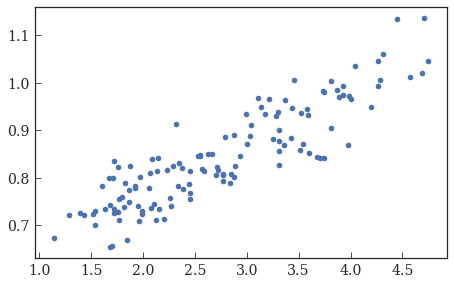

In [41]:
plt.plot(myDataFrame['deltaX_2turns'].values,myDataFrame['WS_geom_emittance_x'],'o')

# Methods comparison

## 1) Single BPM method

In [42]:
bpm_n1 = 18
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 25
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM45 betax=22.64823339 alphax=0.08769178
Expected value for the fit a=0.0222465441548
At PR.BPM60 betax=12.15900765 alphax=0.04780143
Expected value for the fit a=0.04121573921


Model function: a(x)^2 + c
Fit params: a=0.010591022542 c= 7.42253331224e-07
 
At PR.BPM45 betax=22.64823339 alphax=0.08769178
Expected value for the fit a=0.0222465441548


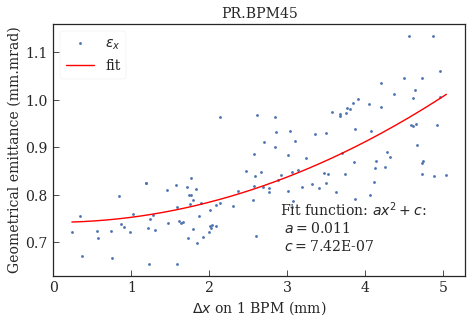

In [43]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

In [44]:
curve_fit?

TypeError: least_squares() got an unexpected keyword argument 'maxfev'

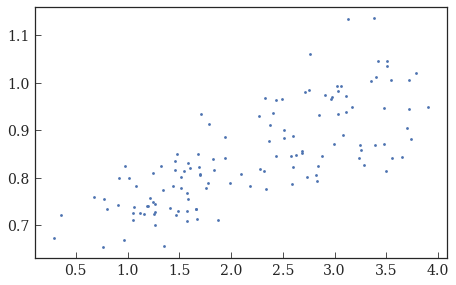

In [45]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

bounds=([0., -np.inf, -np.inf],[np.inf, np.inf, np.inf])
p0 = ([0.011, 0., 0.])
p, cov = curve_fit(f_to_fit,xdata,ydata,maxfev=10000,bounds=bounds,p0=p0)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.05, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))
print 'Theoretically a=(1+alpha^2)/2beta'

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('single_BPM185.eps', format='eps')

## 2) All BPM - single turn method

Model function: a(x)^2 + c
Fit params: a=0.0174712306312 c= 6.9831436279e-07
 
Expected value for the fit a=0.03125


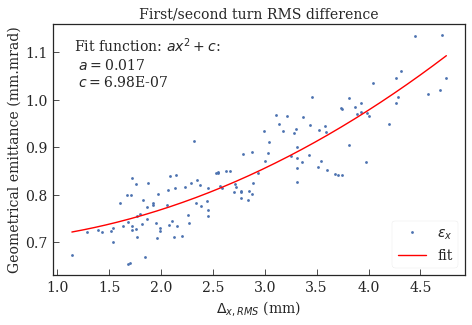

In [46]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.95, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True,loc=4)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

# Laslett tune shift calculation

In [81]:
myDataFrame['peakLineDensity'] = 0.6

In [82]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [83]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

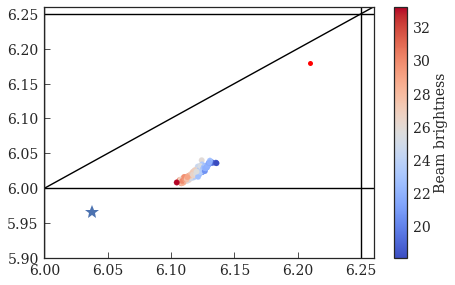

In [98]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.21
Qy = 6.18
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.0, 6.26])
plt.ylim([5.9, 6.26])
# tune shifts
p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.6, 0.5e-3,
              1e-6*0.943, 1e-6*0.775,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [95]:
myDataFrame['WS_emittance_y'].min()

0.80106210163967961